In [ ]:
# 필요한 라이브러리 설치
!pip install roboflow
!pip install mediapipe
!pip install shap
!pip install opencv-python

In [ ]:
# 필요한 라이브러리 import
import roboflow
import mediapipe as mp
import shap
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import cv2
import os

# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# 이미지를 로드하고 포인트 검출하여 특징 추출
def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    keypoints = []
    if results.pose_landmarks:
        mapping = {
            "wrist": [15, 16],
            "elbow": [13, 14],
            "shoulder": [11, 12]
        }
        for part, indices in mapping.items():
            for idx in indices:
                keypoints.extend([results.pose_landmarks.landmark[idx].x, results.pose_landmarks.landmark[idx].y])
    return keypoints

# 로보플로우에서 생성된 데이터셋 다운로드 링크
download_link = "https://app.roboflow.com/ds/2pyPAQpO2Y?key=zyxmZi1KqM"

# 데이터셋 다운로드
dataset_path = "/content/dataset"
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# 데이터셋 다운로드
os.system(f"wget {download_link} -O /content/dataset.zip")
os.system(f"unzip /content/dataset.zip -d {dataset_path}")

# 클래스별로 데이터셋 분류
data = []
class_mapping = {
    "Pull": 0,
    "Push": 1,
    "Middle": 2
}

# class_data 정의
class_data = {
    "Pull": [],
    "Push": [],
    "Middle": []
}

for class_name, label in class_mapping.items():
    class_path = os.path.join(dataset_path, "train", class_name)
    image_files = os.listdir(class_path)
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        features = extract_features_from_image(image_path)
        data.append((features, label))
        # 클래스별로 데이터 추가
        class_data[class_name].append(features)

# 데이터셋을 X, y로 분리
X = np.array([d[0] for d in data])
y = np.array([d[1] for d in data])

In [ ]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression 모델 생성 및 학습
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X, y)

# SHAP 분석을 위한 준비 (Logistic Regression 모델은 KernelExplainer 사용)
explainer = shap.KernelExplainer(logistic_model.predict_proba, X)

# 특징 이름 목록 설정
feature_names = [
    'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y',
    'left_elbow_x', 'left_elbow_y', 'right_elbow_x', 'right_elbow_y',
    'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y'
]

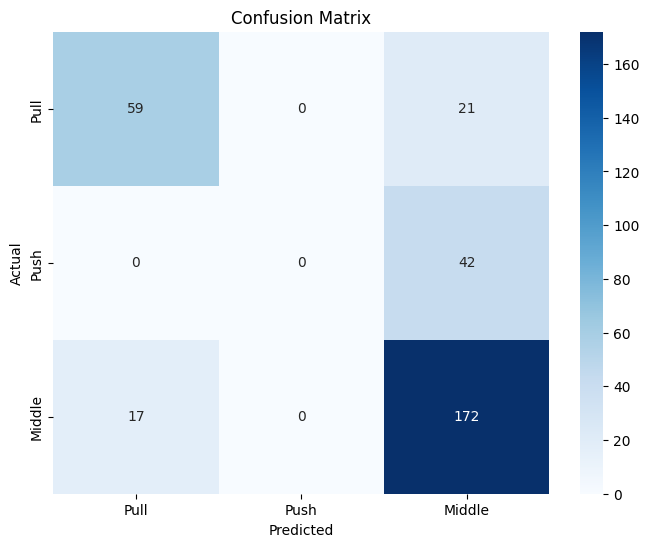

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값 계산
y_pred = logistic_model.predict(X)

# 혼동 행렬 계산
cm = confusion_matrix(y, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


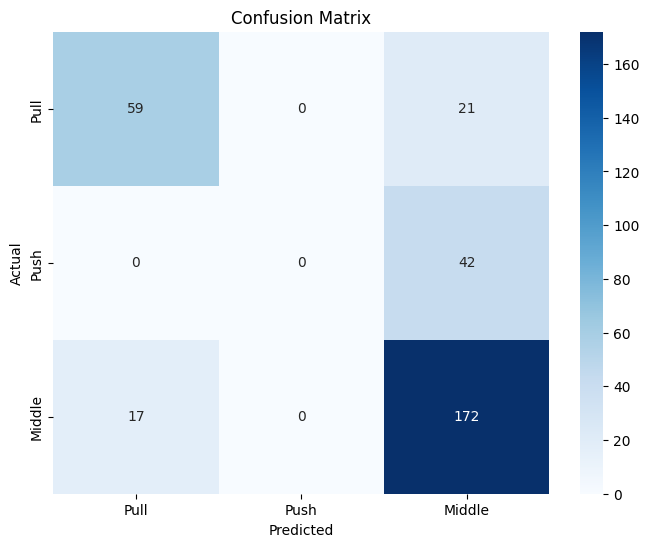

Accuracy: 0.7428
Precision: 0.6445
Recall: 0.7428
F1 Score: 0.6876


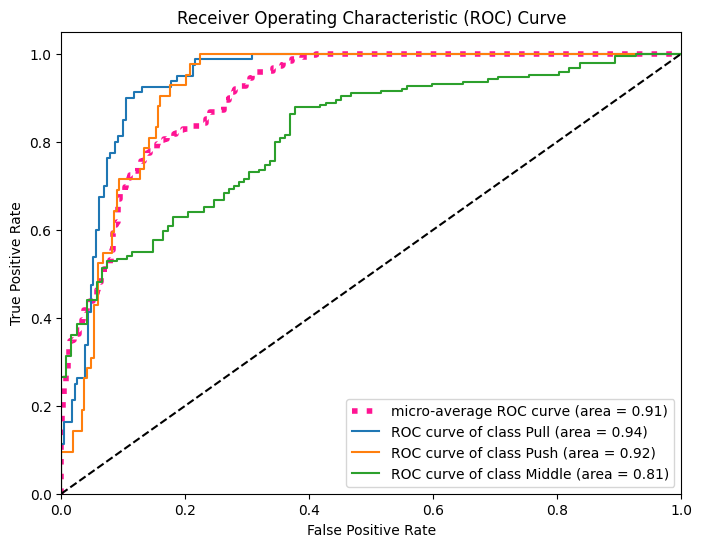

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값 계산
y_pred = logistic_model.predict(X)

# 혼동 행렬 계산
cm = confusion_matrix(y, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 정확도 계산
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 정밀도, 재현율, F1 점수 계산
precision = precision_score(y, y_pred, average='weighted', zero_division=0)
recall = recall_score(y, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 각 클래스를 이진 분류로 변환
y_binarized = label_binarize(y, classes=[0, 1, 2])

# 예측 확률 계산
y_scores = logistic_model.predict_proba(X)

# 클래스 별 ROC curve 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 마이크로 평균 ROC curve 및 AUC 계산
fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i, class_name in enumerate(class_mapping.keys()):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import cv2
import mediapipe as mp

# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# 비디오 경로
video_path = '/content/sample_video.mp4'  # 비디오 파일 경로를 여기에 입력하세요

# 비디오 캡처 객체 생성
cap = cv2.VideoCapture(video_path)

# FPS 측정을 위한 변수 초기화
frame_count = 0
start_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 이미지를 RGB로 변환하여 Mediapipe에 입력
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    # FPS 계산
    frame_count += 1
    elapsed_time = time.time() - start_time
    current_fps = frame_count / elapsed_time
    print(f"Current FPS: {current_fps:.2f}")

# 평균 FPS 계산
average_fps = frame_count / (time.time() - start_time)
print(f"Average FPS: {average_fps:.2f}")

# 리소스 해제
cap.release()


Current FPS: 2.67
Current FPS: 4.39
Current FPS: 5.71
Current FPS: 6.74
Current FPS: 7.57
Current FPS: 8.26
Current FPS: 8.82
Current FPS: 9.29
Current FPS: 9.16
Current FPS: 9.48
Current FPS: 9.77
Current FPS: 10.07
Current FPS: 10.20
Current FPS: 10.37
Current FPS: 10.41
Current FPS: 10.63
Current FPS: 10.75
Current FPS: 10.90
Current FPS: 11.02
Current FPS: 10.89
Current FPS: 11.02
Current FPS: 11.18
Current FPS: 11.29
Current FPS: 11.42
Current FPS: 11.54
Current FPS: 11.67
Current FPS: 11.76
Current FPS: 11.42
Current FPS: 11.23
Current FPS: 10.89
Current FPS: 10.96
Current FPS: 11.07
Current FPS: 11.06
Current FPS: 11.12
Current FPS: 11.04
Current FPS: 10.91
Current FPS: 10.71
Current FPS: 10.66
Current FPS: 10.74
Current FPS: 10.65
Current FPS: 10.61
Current FPS: 10.68
Current FPS: 10.67
Current FPS: 10.73
Current FPS: 10.79
Current FPS: 10.85
Current FPS: 10.92
Current FPS: 11.00
Current FPS: 11.03
Current FPS: 11.09
Current FPS: 11.14
Current FPS: 11.14
Current FPS: 11.05
Curr

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 모델 예측값 계산
y_pred = logistic_model.predict(X)

# 성능 평가 지표 계산
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

# 성능 지표 출력
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Accuracy: 0.74
Precision: 0.64
Recall: 0.74
F1-score: 0.69


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/80 [00:00<?, ?it/s]

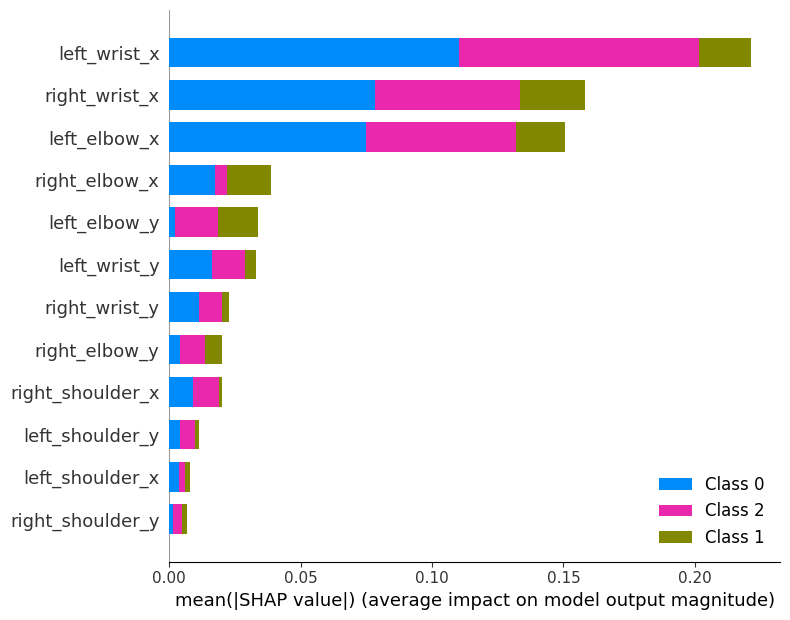

  0%|          | 0/42 [00:00<?, ?it/s]

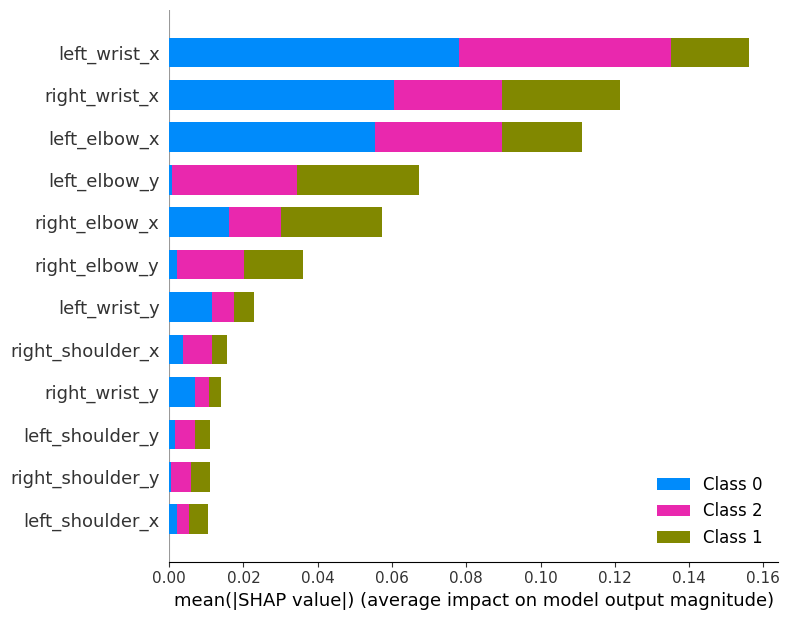

  0%|          | 0/189 [00:00<?, ?it/s]

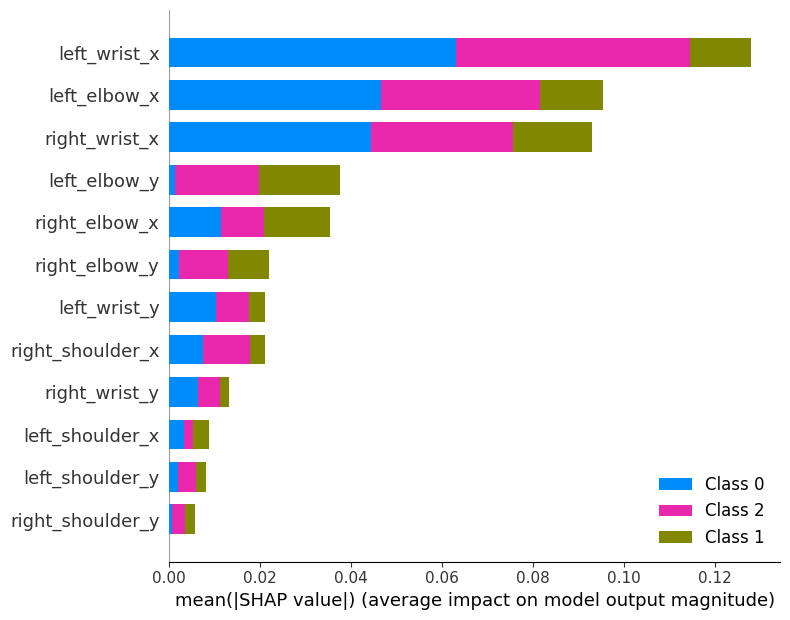

<Figure size 640x480 with 0 Axes>

Saved results for Middle in: /content/results_Middle.png


In [ ]:
# Logistic Regression 모델 생성 및 학습
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X, y)

# SHAP 분석을 위한 준비 (Logistic Regression 모델은 KernelExplainer 사용)
explainer = shap.KernelExplainer(logistic_model.predict_proba, X)

# 특징 이름 목록 설정
feature_names = [
    'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y',
    'left_elbow_x', 'left_elbow_y', 'right_elbow_x', 'right_elbow_y',
    'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y'
]

# 클래스별 SHAP 분석 및 시각화
for class_name, class_features in class_data.items():
    class_features = np.array(class_features)
    class_X = X[y == class_mapping[class_name]]

    # 특정 관절 인덱스 설정
    wrist_left_idx = feature_names.index('left_wrist_x')
    wrist_right_idx = feature_names.index('right_wrist_x')
    elbow_left_idx = feature_names.index('left_elbow_x')
    elbow_right_idx = feature_names.index('right_elbow_x')
    shoulder_left_idx = feature_names.index('left_shoulder_x')
    shoulder_right_idx = feature_names.index('right_shoulder_x')
    feature_indices = [
        wrist_left_idx, wrist_left_idx + 1, wrist_right_idx, wrist_right_idx + 1,
        elbow_left_idx, elbow_left_idx + 1, elbow_right_idx, elbow_right_idx + 1,
        shoulder_left_idx, shoulder_left_idx + 1, shoulder_right_idx, shoulder_right_idx + 1
    ]

    # 특정 관절만을 가지고 SHAP 값을 다시 계산
    class_X_selected = class_X[:, feature_indices]
    shap_values_class = explainer.shap_values(class_X_selected)

    # SHAP 그래프 생성
    shap.summary_plot(
        shap_values_class, class_X_selected,
        feature_names=feature_names
    )

# 결과를 파일로 저장
results_file_path = f"results_{class_name}.png"
plt.savefig(results_file_path)
plt.show()
print(f"Saved results for {class_name} in: {os.path.abspath(results_file_path)}")

In [ ]:
# 예시로 Force plot 생성
sample_data = X[0]
shap_values = explainer.shap_values(sample_data)

shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0],
    feature_names=feature_names
)

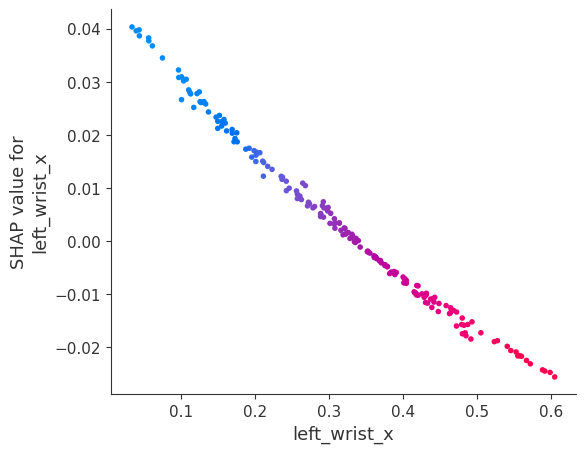

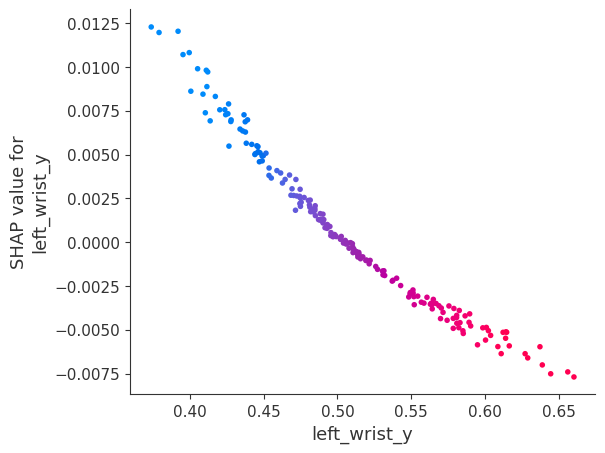

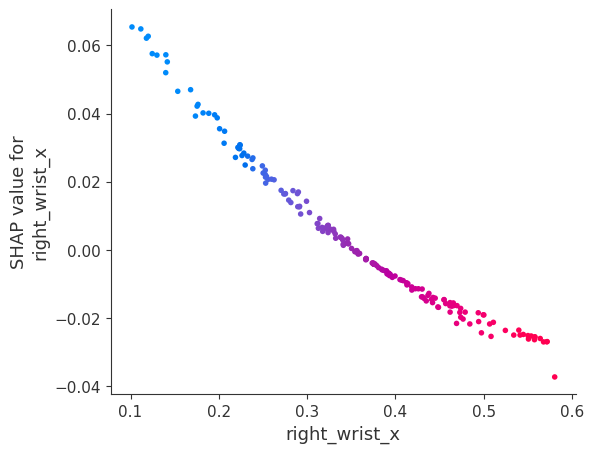

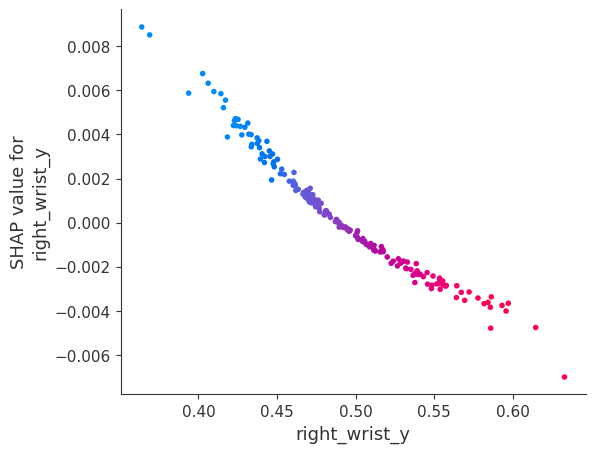

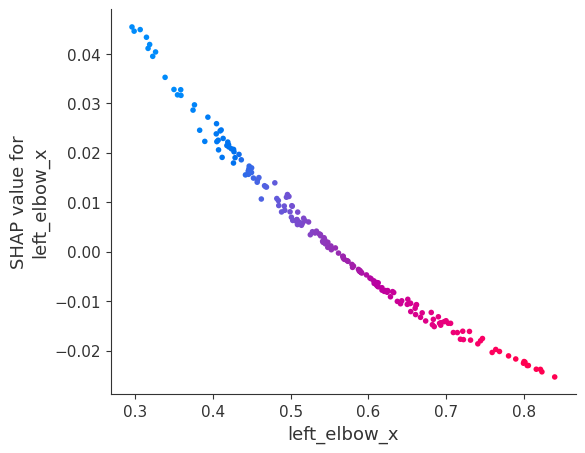

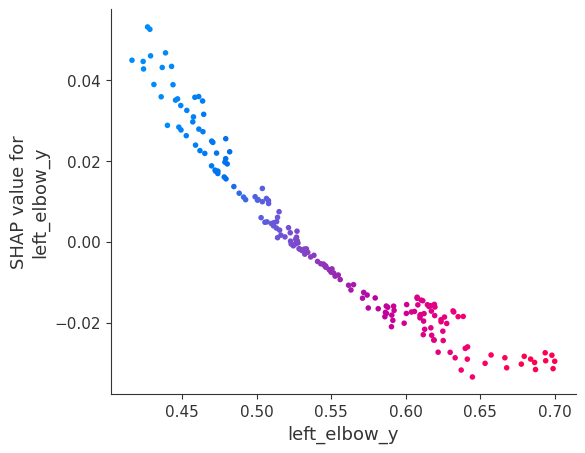

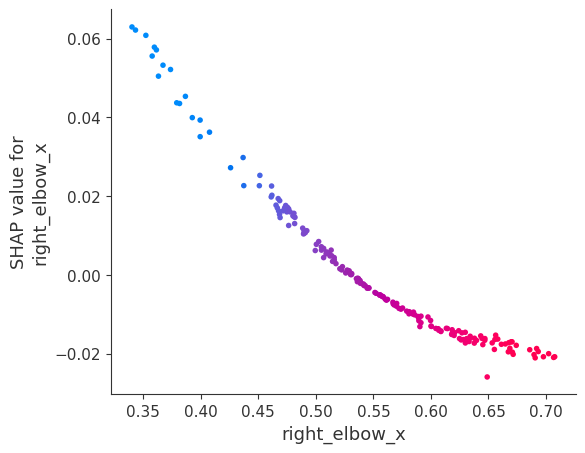

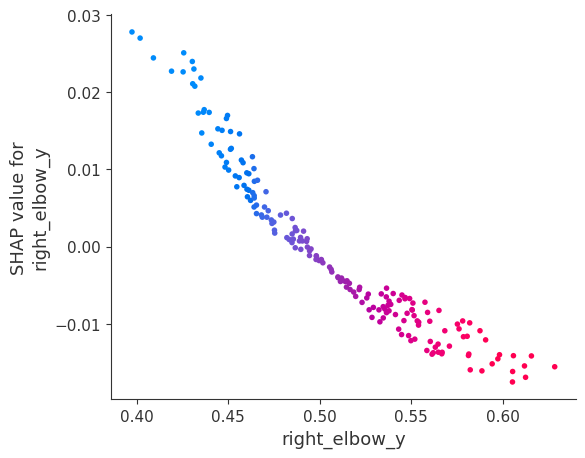

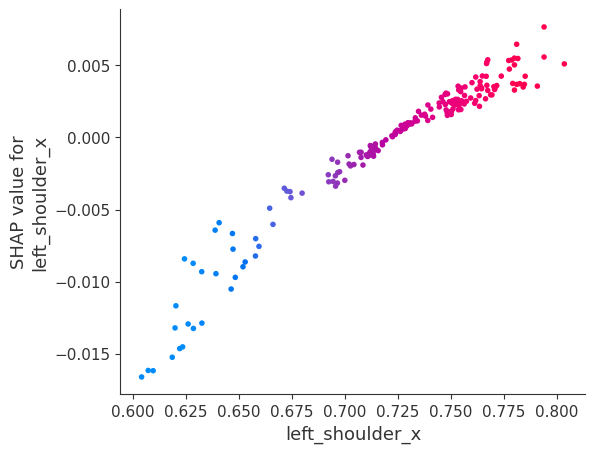

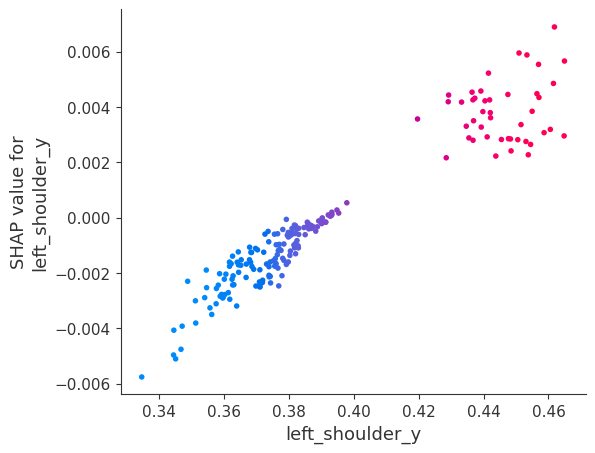

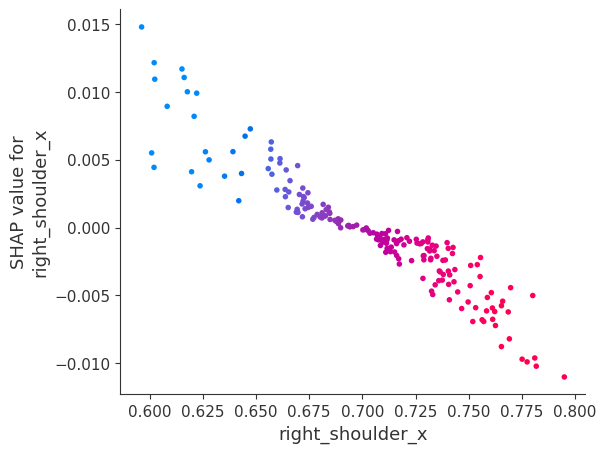

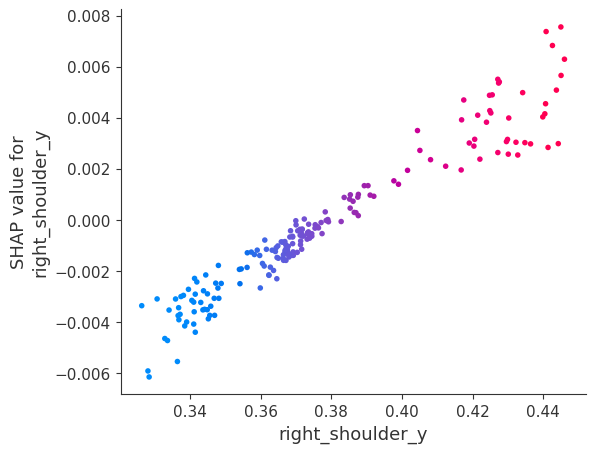

In [ ]:
# 모든 특징에 대한 Dependency plot 생성
for feature_name in feature_names:
    shap.dependence_plot(
        feature_name,
        shap_values_class[1],
        class_X_selected,
        feature_names=feature_names,
        interaction_index=feature_name
    )